In [1]:
import shapely
import pyproj
import fiona
import rasterio
import geopandas 
import pandas
from pandas import notnull

import os
import json
import geojson
import unicodedata

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_file = os.path.join("./image_test.tif") #os.path.abspath('..'), 'data', 'landsat.tif')
#input_file = os.path.join("./no_canny_test.tif")

In [3]:
with rasterio.open(input_file) as src:
    meta_data = src.meta
    band = src.read(1)
    
    for i in [x for x in meta_data]:
        print i.upper() + ': ', meta_data[i]

COUNT:  1
CRS:  CRS({'init': u'epsg:4326'})
DTYPE:  float64
AFFINE:  | 0.00, 0.00,-106.21|
| 0.00,-0.00, 37.50|
| 0.00, 0.00, 1.00|
DRIVER:  GTiff
TRANSFORM:  (-106.21320593315575, 0.00026949458523585647, 0.0, 37.495051138449945, 0.0, -0.00026949458523585647)
HEIGHT:  713
WIDTH:  1163
NODATA:  None


In [4]:
image_height_to_width_ratio = float(meta_data['height']) / float(meta_data['width'])
image_height_to_width_ratio

0.6130696474634566

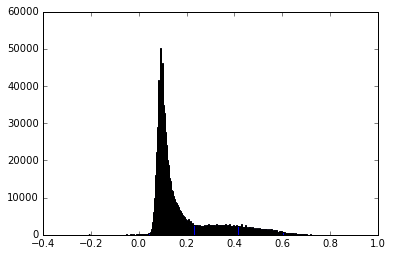

In [5]:
plt.hist(np.ravel(band), bins=260)
plt.show()

In [6]:
15.0*image_height_to_width_ratio

9.19604471195185

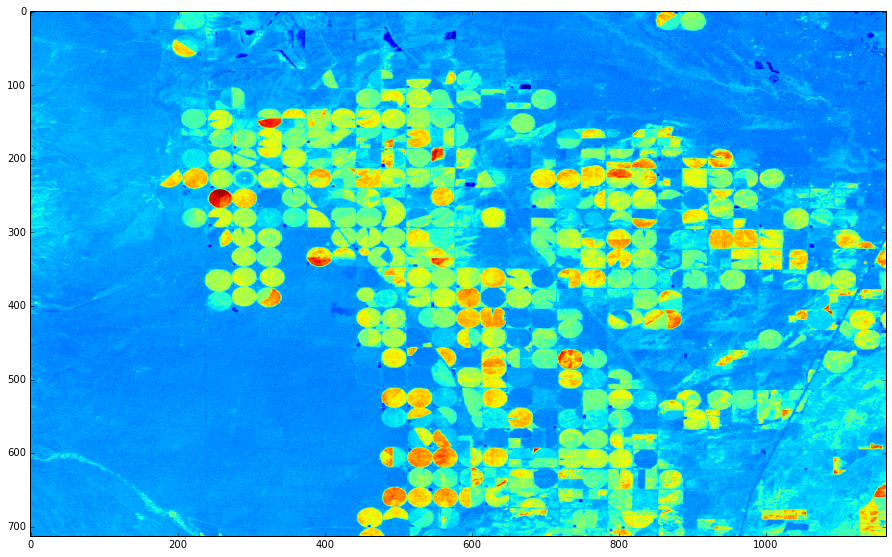

In [7]:
plt.figure(figsize=(25.0*image_height_to_width_ratio,25.0))
plt.imshow(band) #, cmap='gray')
plt.show()

In [8]:
#from skimage.feature import corner_harris, corner_subpix, corner_peaks
#from skimage.transform import warp, AffineTransform

In [9]:
#tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
#                        translation=(210, 50))
#image = band

#coords = corner_peaks(corner_harris(image), min_distance=5)
#coords_subpix = corner_subpix(image, coords, window_size=13)

### From tutorial: http://www.machinalis.com/blog/python-for-geospatial-data-processing/

In [68]:
import numpy as np
import os

from osgeo import gdal
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# A list of "random" colors (for a nicer output)
COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]

In [69]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [135]:
raster_data_path = "./data/image/2298119ene2016recorteTT.tif"
output_fname = "classification.tiff"
train_data_path = "data/test/"
validation_data_path = "data/train/"


#train_data_path = "data/train/"
#validation_data_path = "data/test/"

In [136]:
with rasterio.open(raster_data_path) as src:
    meta_data = src.meta
    band = src.read(1)
    
    for i in [x for x in meta_data]:
        print i.upper() + ': ', meta_data[i]

COUNT:  7
CRS:  CRS({'init': u'epsg:32720'})
DTYPE:  float32
AFFINE:  | 30.00, 0.00, 416415.00|
| 0.00,-30.00, 6663145.00|
| 0.00, 0.00, 1.00|
DRIVER:  GTiff
TRANSFORM:  (416415.0, 30.0, 0.0, 6663145.0, 0.0, -30.0)
HEIGHT:  2500
WIDTH:  1000
NODATA:  None


In [137]:
image_height_to_width_ratio = float(meta_data['height']) / float(meta_data['width'])
image_height_to_width_ratio

2.5

In [138]:
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

In [139]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]

#See image below for sample from shapefiles
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)

is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

In [140]:
print training_samples.shape
print training_labels.shape

(2398, 7)
(2398,)


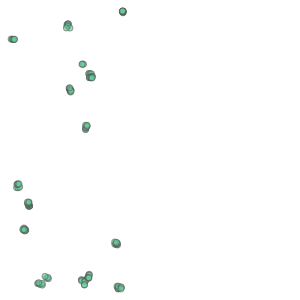

In [155]:
from shapely.geometry import shape

c = fiona.open(shapefiles[1])
pol = c.next()
geom = shape(pol['geometry'])
geom

In [142]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [143]:
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

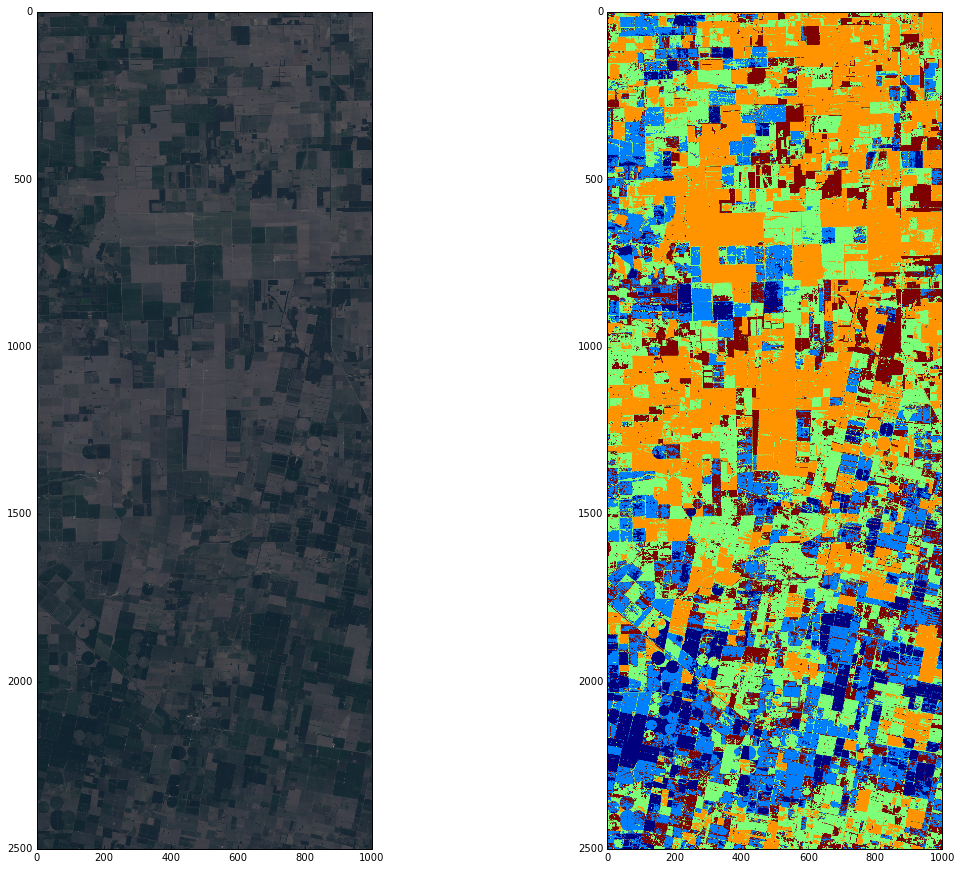

In [144]:
from matplotlib import pyplot as plt
f = plt.figure(figsize=(15.0*image_height_to_width_ratio, 15.0))
f.add_subplot(1, 2, 2)
r = bands_data[:,:,3]
g = bands_data[:,:,2]
b = bands_data[:,:,1]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 1, 1)
plt.imshow(rgb/255)
f.add_subplot(1, 2, 2)
plt.imshow(classification)

In [145]:
write_geotiff(output_fname, classification, geo_transform, proj)

In [146]:
shapefiles = [os.path.join(validation_data_path, "%s.shp" % c)
              for c in classes]
verification_pixels = vectors_to_raster(shapefiles, rows, cols,
                                        geo_transform, proj)
for_verification = np.nonzero(verification_pixels)
verification_labels = verification_pixels[for_verification]
predicted_labels = classification[for_verification]

In [147]:
print("Confussion matrix:\n%s" %
      metrics.confusion_matrix(verification_labels, predicted_labels))

Confussion matrix:
[[171  11   0   0   1]
 [ 18 114   1   0   8]
 [  0   0 176  20   0]
 [  0   0  32 408   1]
 [  0   4   1   0 373]]


In [148]:
target_names = ['Class %s' % s for s in classes]
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=target_names))
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification report:
             precision    recall  f1-score   support

    Class A       0.90      0.93      0.92       183
    Class B       0.88      0.81      0.84       141
    Class C       0.84      0.90      0.87       196
    Class D       0.95      0.93      0.94       441
    Class E       0.97      0.99      0.98       378

avg / total       0.93      0.93      0.93      1339

Classification accuracy: 0.927558
